In [241]:
# Basic imports
import os
master_dir  = os.getcwd()  # the main working directory
data_dir    = os.path.join(master_dir, "Data")  # sub directory where we save data files
plots_dir   = os.path.join(master_dir, "Plots")  # sub directory where we save plots
import numpy as np
import pandas as pd
from typing import Callable, Any
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 5)
import seaborn as sn
from  matplotlib.colors import LinearSegmentedColormap
my_cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

# General classes and functions

In [42]:
class Trajectory:
    
    def __init__(self, x: np.array, y: np.array, z: None):
        
        self.x = x
        self.y = y
        self.z = z
        
        # In case we are dealing with the 2D case
        if self.z is None:
            self.path = np.array([[x[i], y[i]] for i in range(len(x))])
        
        # For the 3D case:
        else: 
            self.path = np.array([[x[i], y[i], z[i]] for i in range(len(x))])
        
        self.start = self.path[0]
        self.end = self.path[-1]

In [139]:
class Hop:
    """
    Discusses the results from analyzing the flows of a Hopfield network
    """
    
    def __init__(self, df: pd.DataFrame, dim: int) -> None:
        
        # Define fields
        self.trajectories = []
        self.attractors   = []
        
        # Dimensionality
        self.dim = dim
        
        # Initialize fields: process all data and get the attractors of the network
        self.compile_data(df)
        self.compile_attractors()
        
        
    def append(self, trajectory: Trajectory) -> None:
        """Append a trajectory from the Hopfield network

        Args:
            trajectory (Trajectory): New trajectory from the Hopfield network to be added to the discussion.
        """
        
        self.trajectories.append(trajectory)
        
    def compile_attractors(self, threshold: float = 0.01) -> None:
        
        # Save all the attractors, already remove exact duplicates
        attractors = np.unique([traj.end for traj in self.trajectories], axis=0)
        # Still have to filter out duplicates based on distance
        saved_list = [attractors[0]]
        for attr in attractors:
            # Compute the distances between saved attractors and next attractor
            closest_distance = np.min([distance(attr, saved_attr) for saved_attr in saved_list])
            # If this distance is above the threshold, attractors are different
            if closest_distance > threshold:
                saved_list.append(attr)
                
        self.attractors = np.array(saved_list)
            
        
    def compile_data(self, df: pd.DataFrame) -> None:
        
        # Check how many trajectories are in the CSV file (1 trajectory = D rows, D = dimensionality)
        nb_trajectories = len(df) // self.dim
        
        for i in range(nb_trajectories):
            # Certainly get the next x and y
            x, y = df.loc[self.dim*i].values, df.loc[self.dim*i + 1].values
            # Check if there is a z value or not
            if self.dim == 2:
                z = None
            else:
                z = df.loc[2*i + 2].values
            # Create trajectory object and save it
            new_trajectory = Trajectory(x, y, z)
            self.append(new_trajectory)

In [ ]:
def distance(v1: np.array, v2: np.array):
    
    return np.sqrt(np.sum((v1 - v2)**2))

In [ ]:
def is_in(point: np.array, list_of_points: np.array) -> None:
    """Simple auxiliary function that checks whether a given point as numpy array is within a given list of points by checking the coordinates

    Args:
        point (np.array): Single point, a numpy array, that has to be checked against a list of points.
        list_of_points (np.array): A list of points to compare against point. 

    Returns:
        None: void return
    """
    
    # Loop over all points of the list of points
    for other_point in list_of_points:
        # If all coordinates agree, it is among the list
        if np.all(point == other_point):
            return True
    
    return False

Colors for the attractors

In [175]:
COLORS = ["red", "blue", "orange", "green", "cadetblue", "magenta", "purple", "lightslategrey", "darkred"]

In [ ]:
def get_color(end_point: np.array, attractors: np.array) -> str:
    """Gives a color to a point based on the distance to the attractors. 

    Args:
        end_point (np.array): End point of a trajectory, for which we want to determine the closest attractor or closest color.
        attractors (np.array): List of attractor locations to compare distances.

    Returns:
        str: Description of the color used as encoding for the closest attractor
    """
    
    # Get the Euclidean distances between the end point and all attractors
    distances = [distance(end_point, attr) for attr in attractors]
    # Get the index of the attractor closest to endpoint
    best_index = np.argmin(distances)
    
    return COLORS[best_index]

In [ ]:
def compute_convergence_index(trajectory: Trajectory, attractors):
    path = trajectory.path
    for i in range(len(path)):
        if is_in(path[i], attractors):
            return i

# 2D Hopfield network

Read in the data

In [176]:
# Import the data for comparison
df = pd.read_csv(os.path.join(data_dir, "hop_2D_trajectories.csv"), header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-0.9,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.8,0.929467,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
878,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
879,0.9,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
880,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1


Process a 2D dataframe containing the trajectories and information

In [177]:
hop = Hop(df, 2)

Show the attractors

In [178]:
print(hop.attractors)
print(f"There are {len(hop.attractors)} attractors in this Hopfield network.")

[[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
There are 9 attractors in this Hopfield network.


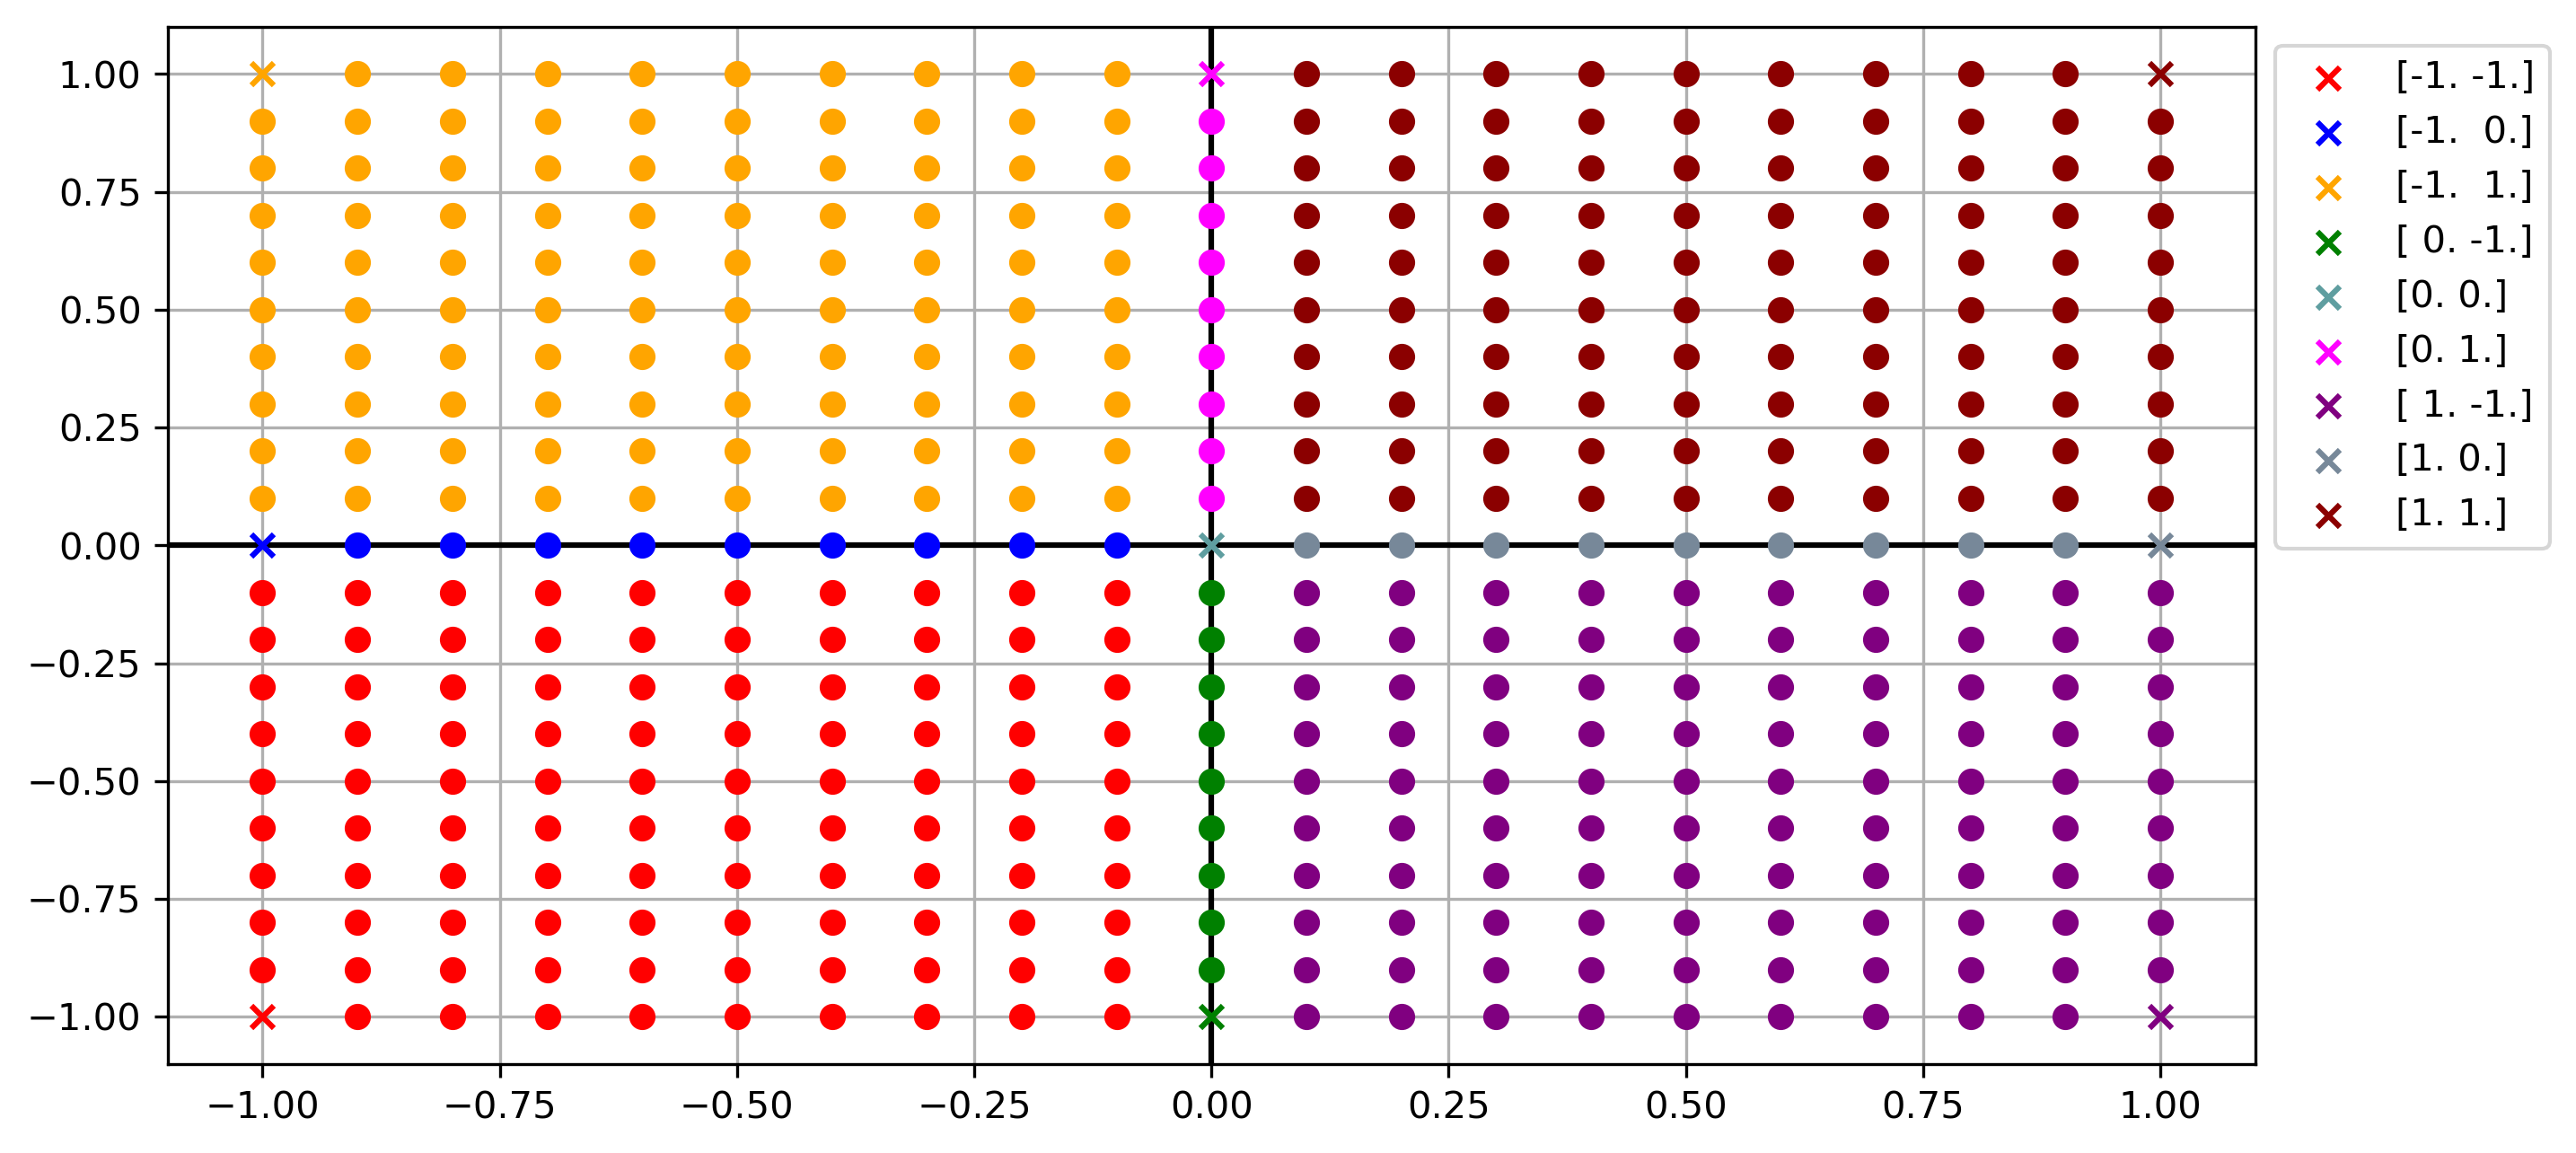

In [184]:
delta = 0.1

# Plot the end result of each trajectory
for trajectory in hop.trajectories:
    # Do not plot the trajectories that start at an attractor - will be plotted separately
    if is_in(trajectory.start, hop.attractors):
        continue
    plt.scatter(trajectory.start[0], trajectory.start[1], color = get_color(trajectory.end, hop.attractors), zorder = 100)
   
# Plot the attractors separately
for i, attr in enumerate(hop.attractors):
    plt.scatter(attr[0], attr[1], color = COLORS[i], label = str(attr), marker="x", zorder = 100)
# Plot each attractor for the color coding 
plt.grid()
plt.legend(bbox_to_anchor=(1.15, 1))  # loc='right', 
plt.xlim(-1-delta, 1+delta)
plt.ylim(-1-delta, 1+delta)
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.savefig(os.path.join(plots_dir, "Hop2D_start_points_coloured.pdf"), bbox_inches='tight')
plt.show()

Plot entire trajectories

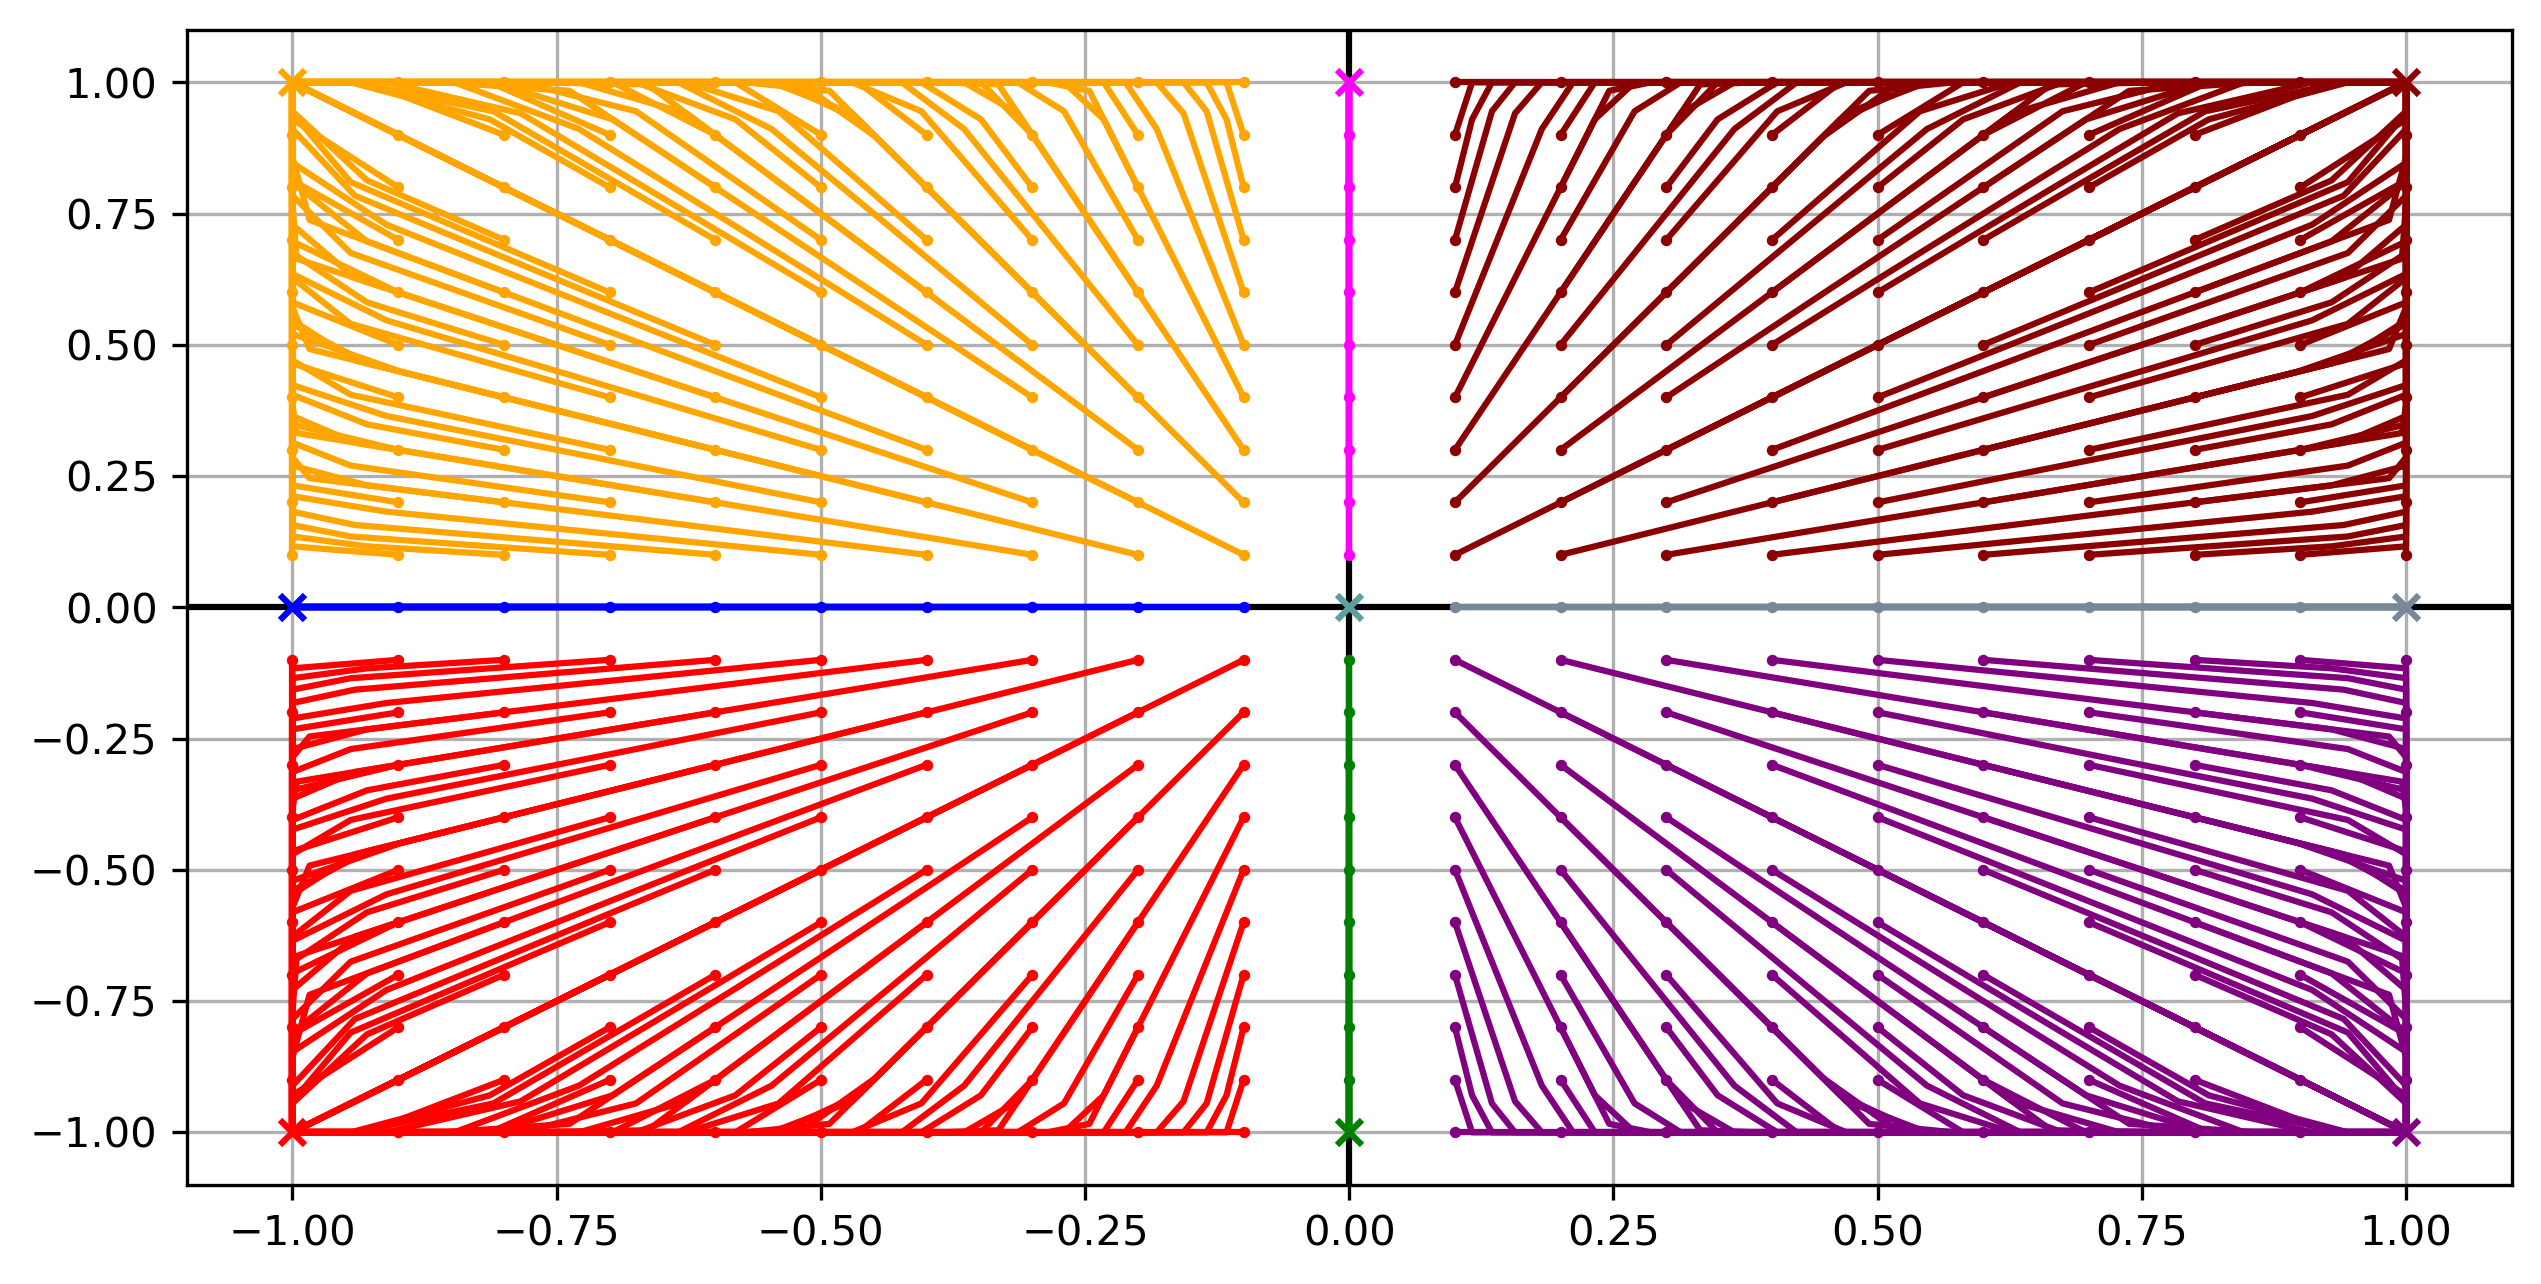

In [185]:
delta = 0.1

# Plot the end result of each trajectory
for trajectory in hop.trajectories:
    if is_in(trajectory.start, hop.attractors):
        continue
    # Get color based on distance to attactors
    color = get_color(trajectory.end, hop.attractors)
    plt.scatter(trajectory.start[0], trajectory.start[1], color = color, s = 3, zorder = 100)
    plt.plot(trajectory.path[:, 0], trajectory.path[:, 1], color = color, zorder = 100)
   
# Plot the attractors separately
for i, attr in enumerate(hop.attractors):
    plt.scatter(attr[0], attr[1], color = COLORS[i], label = str(attr), marker="x", zorder = 100)
# Plot each attractor for the color coding 
plt.grid()
# plt.legend(bbox_to_anchor=(1.15, 1))  # loc='right', 
plt.xlim(-1-delta, 1+delta)
plt.ylim(-1-delta, 1+delta)
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.savefig(os.path.join(plots_dir, "Hop2D_trajectories_coloured.pdf"), bbox_inches='tight')
plt.show()

In [ ]:
indices = []
for trajectory in hop.trajectories:
    indices.append(compute_convergence_index(trajectory, hop.attractors))
print(f"Average number of iterations: {np.mean(indices), np.std(indices)}")

# 3D Hopfield network

Read in the data

In [186]:
# Import the data for comparison
df = pd.read_csv(os.path.join(data_dir, "hop_3D_trajectories.csv"), header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,-0.750,-0.351847,-0.216650,-0.144181,-0.105334,-0.084512,-0.073350,-0.067367,-0.064160,-0.062441,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-0.750,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-0.750,-0.351847,-0.216650,-0.144181,-0.105334,-0.084512,-0.073350,-0.067367,-0.064160,-0.062441,...,1,1,1,1,1,1,1,1,1,1
3,-0.750,-0.234509,-0.153754,-0.110466,-0.087262,-0.074824,-0.068157,-0.064584,-0.062668,-0.061641,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-0.375,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.375,0.502850,0.645313,0.809475,0.999902,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
371,0.750,0.804214,0.873279,0.954876,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
372,0.750,0.921552,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
373,0.750,0.821199,0.989001,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1


Process a 3D dataframe containing the trajectories and information

In [187]:
hop = Hop(df, 3)

In [188]:
print(hop.attractors)
print(f"There are {len(hop.attractors)} attractors in this Hopfield network.")

[[-1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1.  1.]
 [ 1.  1. -1.]
 [ 1.  1.  1.]]
There are 6 attractors in this Hopfield network.


Make a plot:

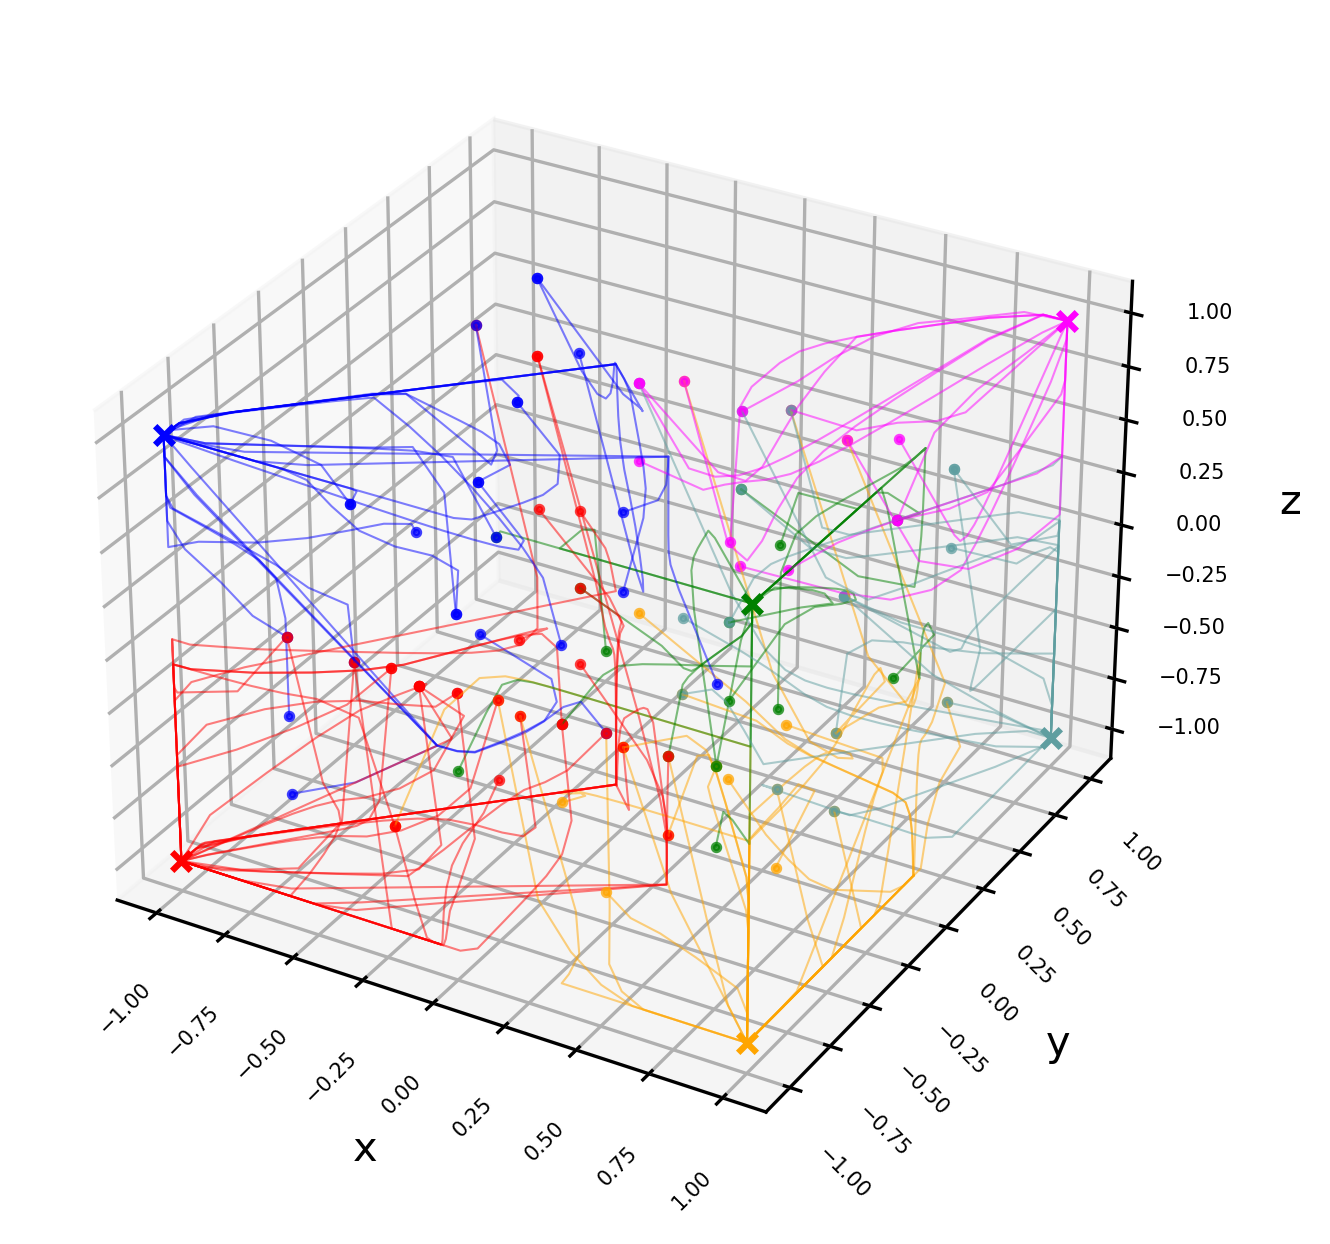

In [189]:
delta = 0.1

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')

# Plot the end result of each trajectory
for trajectory in hop.trajectories:
    if is_in(trajectory.start, hop.attractors):
        continue
    # Get color based on distance to attactors
    color = get_color(trajectory.end, hop.attractors)
    ax.scatter3D(trajectory.start[0], trajectory.start[1], trajectory.start[2], color = color, s = 3, alpha=0.75, zorder = 100)
    ax.plot3D(trajectory.path[:, 0], trajectory.path[:, 1], trajectory.path[:, 2], lw = 0.5, color = color, alpha=0.5, zorder = 100)
   
# Plot the attractors separately
for i, attr in enumerate(hop.attractors):
    ax.scatter3D(attr[0], attr[1], attr[2], color = COLORS[i], marker="x", zorder = 100)
# Plot each attractor for the color coding 
ax.grid()
ax.set_xlim(-1-delta, 1+delta)
ax.set_ylim(-1-delta, 1+delta)
ax.set_zlim(-1-delta, 1+delta)
# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Rotate y-tick labels
for tick in ax.get_yticklabels():
    tick.set_rotation(-45)
# Decrease the size of the ticks for each axis
lab_size = 5
ax.tick_params(axis='x', which='both', labelsize=lab_size)
ax.tick_params(axis='y', which='both', labelsize=lab_size)
ax.tick_params(axis='z', which='both', labelsize=lab_size)
plt.savefig(os.path.join(plots_dir, "Hop3D_trajectories_coloured.pdf"), bbox_inches='tight')

plt.show()

We check explicitly that the two other "corner points" are no fixed points

In [198]:
A = np.array([0.8489, 0.3129, -0.3129, 0.3129, 0.8489, 0.3129, -0.3129, 0.3129, 0.8489]).reshape(3, 3)
b = np.array([0.2849, -0.2849, 0.2849]).reshape(3, 1)

In [201]:
def is_fixed_point(point: np.array, weight: np.array, bias: np.array, threshold: float = 1e-4):
    next = np.matmul(weight, point) + bias
    if distance(point, next) < threshold:
        return True
    else:
        return False

In [202]:
#1
point = np.array([-1, 1, -1]).reshape(3, 1)
true_false = is_fixed_point(point, A, b)
print(f"{point.flatten()} is a fixed point? {true_false}")
#2
point = np.array([-1, 1, 1]).reshape(3, 1)
true_false = is_fixed_point(point, A, b)
print(f"{point.flatten()} is a fixed point? {true_false}")

[-1  1 -1] is a fixed point? False
[-1  1  1] is a fixed point? False


Now, we answer the question, how many iterations does it take before reaching the final state?

In [ ]:
indices = []
for trajectory in hop.trajectories:
    indices.append(compute_convergence_index(trajectory, hop.attractors))
print(f"Average number of iterations: {np.mean(indices), np.std(indices)}")

# Hopfield digits recognition

In [217]:
# Import the data for comparison
df = pd.read_csv(os.path.join(data_dir, "hopdigits_results.csv"), names=["Noise", "Iterations", "Correct", "Comment"])
df

,Noise,Iterations,Correct,Comment
0,1,50,10,
1,1,100,10,
2,1,500,10,
3,3,50,10,
4,3,100,10,
5,3,500,10,
6,5,50,8,"5 became 3, 8 became 6"
7,5,100,9,4 became 7
8,5,500,10,
9,7,50,8,"5 became 9, 8 became 2"


In [225]:
noise_values = np.unique(df["Noise"].values)
iteration_values = np.unique(df["Iterations"].values)
correct_values = df["Correct"].values.reshape((len(noise_values), len(iteration_values)))

We will turn this data into a more convenient format in order to create a matrix that simplifies plotting:

In [229]:
df_for_plot = pd.DataFrame(correct_values, index = noise_values, columns = iteration_values)
df_for_plot

,50,100,500
1,10,10,10
3,10,10,10
5,8,9,10
7,8,7,6
10,3,4,7


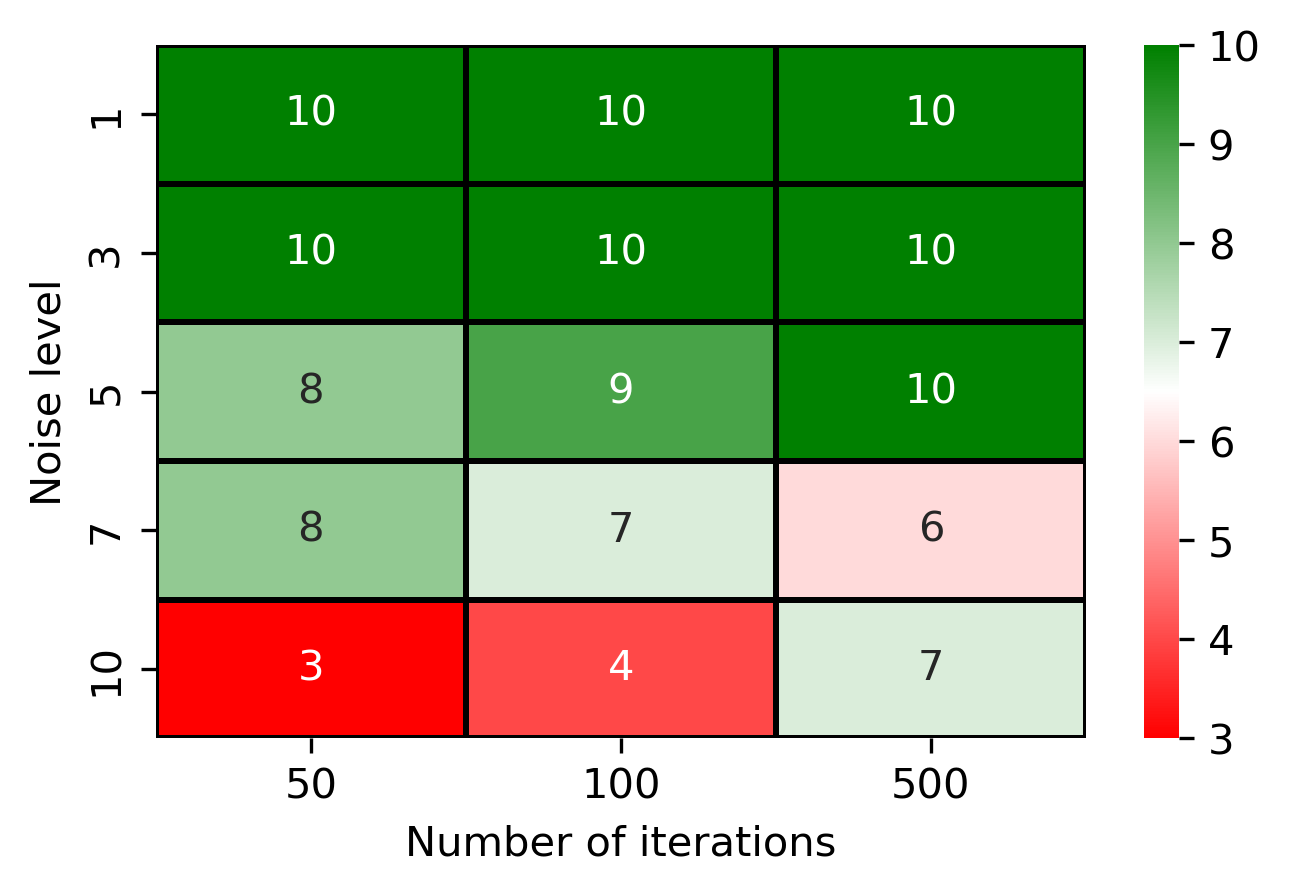

In [240]:
plt.figure(figsize = (5,3))
sn.heatmap(df_for_plot, annot=True, cmap=my_cmap, linewidths=1, linecolor='black')
plt.xlabel("Number of iterations")
plt.ylabel("Noise level")
plt.savefig(os.path.join(plots_dir, "hopdigits_reconstructions.pdf"), bbox_inches = "tight")
plt.show()

# RNN for laser predictions

In [243]:
df = pd.read_csv("RNN_results.csv")
df

,Hidden,p,Train MSE,Test MSE
0,5,25,0.015868,113.932257
1,5,25,0.122031,5.060000
2,5,25,0.093836,3.249925
3,10,25,0.045173,3.740326
4,10,25,0.050360,3.187513
5,10,25,0.087964,5.431402
6,20,25,0.047497,2.796930
7,20,25,0.127790,2.282938
8,20,25,0.056155,2.696023
9,5,50,0.391239,5.789899


In [245]:
mean_df = df.groupby(["Hidden", "p"]).mean()
mean_df

Train MSE   Test MSE
Hidden p                        
5      25    0.077245  40.747394
       50    0.226291   3.661466
       100   0.224539   4.007178
10     25    0.061166   4.119747
       50    0.170525   4.779028
       100   0.270840   4.504194
20     25    0.077147   2.591964
       50    0.139155   3.555432
       100   0.180807   4.474979